In [1]:
%cd ..
%cd ..

/home/ltorres/leo/tesis/cloud-classification/code/notebooks
/home/ltorres/leo/tesis/cloud-classification/code


In [2]:
%load_ext autoreload
%autoreload 2

---

In [3]:
from torchvision.io import read_image
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

In [4]:
from src.dataset import GCD
from src import config
from src import engine_gnn as engine
from src import utils

from src.models.graph_nets import GraphConvGNN, GATConvGNN

from notebooks.adjacency_construction.adjacency_models import *

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
import wandb

#### PARAMS

In [7]:
device = 'cuda:2'


BUILDER = 'cos_sim'
builder_name = "Cosine Similarity"
LR = 3e-4
EPOCHS = 15


exp_name = 'AAAAAAAAAAAAA_06_04_22'
model_filename = f'/adjacency_builders/{exp_name}.pt'

---

In [8]:
wandb.login()

wandb: Currently logged in as: leonardtd (use `wandb login --relogin` to force relogin)


True

#### Data loaders

In [9]:
path_train_images = utils.get_gcd_paths(config.DATA_DIR,'train')

In [10]:
train_dataset = GCD(path_train_images, resize=256)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

In [11]:
path_test_images = utils.get_gcd_paths(config.DATA_DIR,'test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

### Data augmentation data loaders

In [12]:
aug_dataset = GCD(path_train_images, resize=256, aug_types='augmentation')

augmentation_loader = torch.utils.data.DataLoader(
        aug_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

#### Model

In [13]:
from torchvision import models

In [14]:
torch.cuda.empty_cache()

In [15]:
model = GATConvGNN(7, 1024, 2, 4, 0.7, device, adjacency_builder = BUILDER).to(device)

In [16]:
criterion = utils.loge_loss
optimizer  = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

####  wandb

In [17]:
wandb.init(
    # Set the project where this run will be logged
    project="cloud classification - AAAAAAA",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=exp_name, 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "GATConvGNN",
    "loss": "LogeLoss",
    "optim": "SGD",
    "dataset": "GCD",
    "builder": f"{builder_name}",
    "epochs": EPOCHS,
  })

### Train

In [18]:
best_accuracy=0
best_iteration=0
best_params={}

for e in range(EPOCHS):
    ### TRAIN DATASET
    preds, targets, loss = engine.train_fn(model, train_loader, criterion, optimizer, device=device)
    train_acc = accuracy_score(targets, preds)
    
    ### AUGMENTATION IMAGES
    engine.forward_backward_pass(model, augmentation_loader, criterion, optimizer, device=device)
    
    scheduler.step()
    
    test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)
    test_acc = accuracy_score(test_targets, test_preds)
    
    if test_acc > best_accuracy:
        torch.save(model.state_dict(), config.SAVE_PATH+model_filename)
        print(f"Saved best parameters at epoch {e+1}")
        best_accuracy = test_acc
        best_iteration = e+1
        best_params = model.state_dict()
    
    print("EPOCH {}: Train acc: {:.2%} Train Loss: {:.4f} Test acc: {:.2%} Test Loss: {:.4f}".format(
        e+1,
        train_acc,
        loss,
        test_acc,
        test_loss
    ))
    
    metrics = {
                "train/train_loss": loss,
                "train/train_accuracy": train_acc,
                "test/test_loss": test_loss,
                "test/test_accuracy": test_acc,
              }

    wandb.log(metrics)


100%|██████████| 282/282 [00:17<00:00, 15.94it/s]


Saved best parameters at epoch 1
EPOCH 1: Train acc: 65.93% Train Loss: 2.0873 Test acc: 71.27% Test Loss: 1.6558


100%|██████████| 282/282 [00:17<00:00, 15.93it/s]


Saved best parameters at epoch 2
EPOCH 2: Train acc: 86.31% Train Loss: 0.8187 Test acc: 73.10% Test Loss: 1.5668


100%|██████████| 282/282 [00:17<00:00, 16.00it/s]


Saved best parameters at epoch 3
EPOCH 3: Train acc: 88.85% Train Loss: 0.6754 Test acc: 74.47% Test Loss: 1.5080


100%|██████████| 282/282 [00:17<00:00, 15.88it/s]


EPOCH 4: Train acc: 90.98% Train Loss: 0.5599 Test acc: 74.12% Test Loss: 1.5390


100%|██████████| 282/282 [00:17<00:00, 15.92it/s]


Saved best parameters at epoch 5
EPOCH 5: Train acc: 92.09% Train Loss: 0.4861 Test acc: 74.72% Test Loss: 1.4891


100%|██████████| 282/282 [00:17<00:00, 15.76it/s]


Saved best parameters at epoch 6
EPOCH 6: Train acc: 93.40% Train Loss: 0.4138 Test acc: 75.14% Test Loss: 1.4613


100%|██████████| 282/282 [00:17<00:00, 15.93it/s]


EPOCH 7: Train acc: 93.95% Train Loss: 0.3706 Test acc: 74.03% Test Loss: 1.5761


100%|██████████| 282/282 [00:17<00:00, 15.92it/s]


Saved best parameters at epoch 8
EPOCH 8: Train acc: 94.59% Train Loss: 0.3372 Test acc: 75.29% Test Loss: 1.4977


100%|██████████| 282/282 [00:17<00:00, 15.94it/s]


EPOCH 9: Train acc: 95.40% Train Loss: 0.2828 Test acc: 75.02% Test Loss: 1.4937


100%|██████████| 282/282 [00:17<00:00, 15.91it/s]


EPOCH 10: Train acc: 96.31% Train Loss: 0.2373 Test acc: 74.09% Test Loss: 1.5908


100%|██████████| 282/282 [00:17<00:00, 16.00it/s]


EPOCH 11: Train acc: 97.32% Train Loss: 0.1843 Test acc: 74.60% Test Loss: 1.5684


100%|██████████| 282/282 [00:17<00:00, 16.00it/s]


EPOCH 12: Train acc: 97.85% Train Loss: 0.1475 Test acc: 75.03% Test Loss: 1.5390


100%|██████████| 282/282 [00:17<00:00, 16.10it/s]


EPOCH 13: Train acc: 98.23% Train Loss: 0.1274 Test acc: 74.49% Test Loss: 1.5644


100%|██████████| 282/282 [00:17<00:00, 16.06it/s]


EPOCH 14: Train acc: 98.33% Train Loss: 0.1226 Test acc: 74.47% Test Loss: 1.5541


100%|██████████| 282/282 [00:17<00:00, 16.19it/s]

EPOCH 15: Train acc: 98.49% Train Loss: 0.1123 Test acc: 74.96% Test Loss: 1.5342


In [19]:
wandb.finish()

test/test_accuracy,▁▄▇▆▇█▆██▆▇█▇▇▇
test/test_loss,█▅▃▄▂▁▅▂▂▆▅▄▅▄▄
train/train_accuracy,▁▅▆▆▇▇▇▇▇██████
train/train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
test/test_accuracy,0.74956
test/test_loss,1.53424
train/train_accuracy,0.9849
train/train_loss,0.11229


In [27]:
model.load_state_dict(torch.load(config.SAVE_PATH+model_filename))

<All keys matched successfully>

In [28]:
test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)

100%|██████████| 282/282 [00:17<00:00, 16.29it/s]


In [29]:
accuracy_score(test_targets, test_preds)

0.7527777777777778

---

### Accuracy per class and confusion matrix

In [30]:
class_mapper = {
    0: '1_cumulus',
    1: '2_altocumulus',
    2: '3_cirrus',
    3: '4_clearsky',
    4: '5_stratocumulus',
    5: '6_cumulonimbus',
    6: '7_mixed',
}

In [31]:
class_acc = dict()
matrix = np.zeros((7,7), dtype=int)

for i in range(7):
    pred_index = np.where(test_targets==i)[0]
    class_acc[class_mapper[i]] = accuracy_score(test_targets[pred_index], test_preds[pred_index])
    
    for j in test_preds[pred_index]:
        matrix[i,j]+=1 

In [32]:
class_acc

{'1_cumulus': 0.64,
 '2_altocumulus': 0.44533333333333336,
 '3_cirrus': 0.848605577689243,
 '4_clearsky': 0.9760855884203902,
 '5_stratocumulus': 0.6111731843575419,
 '6_cumulonimbus': 0.8641796450561391,
 '7_mixed': 0.4794069192751236}

Global Test accuracy 0.7527777777777778


<AxesSubplot:title={'center':'Confusion Matrix (Accuracy %)'}>

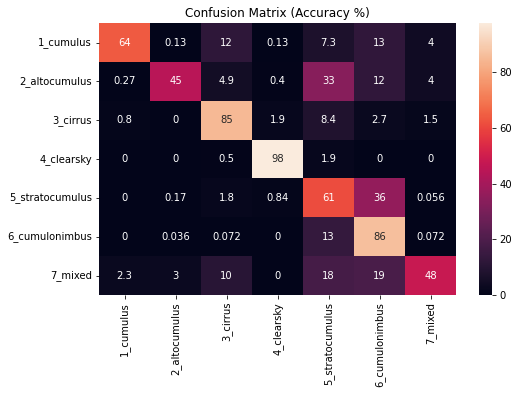

In [33]:
print(f"Global Test accuracy {accuracy_score(test_targets, test_preds)}")

sum_of_rows = matrix.sum(axis=1)
conf_mat = 100*matrix / sum_of_rows[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat, index = class_acc.keys(),
                  columns = class_acc.keys())

plt.figure(figsize = (8,5))
plt.title("Confusion Matrix (Accuracy %)")
sns.heatmap(df_cm, annot=True)